# import and constant

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import joblib

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
dataset_dir = './dataset_word'
model_name = 'sign_classifier_word'

In [2]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.20.0
Num GPUs Available:  0


# Dataset

In [5]:
!curl -L -o ./bisindo-40-kata-mp4.zip\
  https://www.kaggle.com/api/v1/datasets/download/anggiyohanespardede/bisindo-40-kata-mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  719M  100  719M    0     0  10.4M      0  0:01:08  0:01:08 --:--:-- 10.9M.9M    0  0:01:09  0:00:56  0:00:13 10.8M


In [6]:
import zipfile
import os
import platform

zip_path = "./bisindo-40-kata-mp4.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./bisindo-40-kata-mp4.zip ...
✅ Dataset berhasil diekstrak ke ./


In [7]:
import os
import shutil

src_dir = "raw_video"
dst_dir = dataset_dir

if not os.path.exists(src_dir):
    raise FileNotFoundError(f"❌ Folder sumber tidak ditemukan: {src_dir}")

os.makedirs(dst_dir, exist_ok=True)

print(f"📂 Memindahkan isi dari '{src_dir}' ke '{dst_dir}' ...")

for item in os.listdir(src_dir):
    src_path = os.path.join(src_dir, item)
    dst_path = os.path.join(dst_dir, item)
    
    if os.path.exists(dst_path):
        if os.path.isdir(dst_path):
            shutil.rmtree(dst_path)
        else:
            os.remove(dst_path)

    shutil.move(src_path, dst_path)

print(f"✅ Semua isi dari '{src_dir}' berhasil dipindahkan ke '{dst_dir}'")


📂 Memindahkan isi dari 'raw_video' ke './dataset_word' ...
✅ Semua isi dari 'raw_video' berhasil dipindahkan ke './dataset_word'


In [8]:
import shutil
import os

folder_path = "./raw_video"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./raw_video
✅ Folder berhasil dihapus.


In [5]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

In [6]:
data = []
labels = []

print("🎬 Mulai ekstraksi keypoint dari video...\n")

for label_folder in tqdm(sorted(os.listdir(dataset_dir))):
    folder_path = os.path.join(dataset_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if not file.lower().endswith(".mp4"):
            continue

        video_path = os.path.join(folder_path, file)
        cap = cv2.VideoCapture(video_path)

        keypoints_seq = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            hand_keypoints = []

            hand_keypoints = []

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks[:2]:
                    hand = [lm_coord for lm in hand_landmarks.landmark for lm_coord in (lm.x, lm.y, lm.z)]
                    hand_keypoints.append(hand)

            while len(hand_keypoints) < 2:
                hand_keypoints.append([0.0]*63)

            keypoints = np.concatenate(hand_keypoints)
            keypoints_seq.append(keypoints)

        cap.release()

        keypoints_seq = np.array(keypoints_seq)
        max_len = 30
        if len(keypoints_seq) < max_len:
            pad = np.zeros((max_len - len(keypoints_seq), keypoints_seq.shape[1]))
            keypoints_seq = np.vstack((keypoints_seq, pad))
        elif len(keypoints_seq) > max_len:
            keypoints_seq = keypoints_seq[:max_len]

        data.append(keypoints_seq)
        labels.append(label_folder)

        flipped = keypoints_seq.copy()
        flipped[:, ::3] = 1.0 - flipped[:, ::3]
        data.append(flipped)
        labels.append(label_folder)

        noise = keypoints_seq + np.random.normal(0, 0.01, keypoints_seq.shape)
        data.append(noise)
        labels.append(label_folder)

os.makedirs("preprocessing", exist_ok=True)
output_X_path = os.path.join("preprocessing", "X_word.npy")
output_y_path = os.path.join("preprocessing", "y_word.npy")

np.save(output_X_path, np.array(data))
np.save(output_y_path, np.array(labels))

print(f"\n✅ Ekstraksi selesai:")
print(f"📁 Data disimpan ke: {output_X_path}")
print(f"🏷️ Label disimpan ke: {output_y_path}")
print(f"🧩 Jumlah sampel: {len(data)}")

🎬 Mulai ekstraksi keypoint dari video...



100%|██████████| 40/40 [56:39<00:00, 84.99s/it]



✅ Ekstraksi selesai:
📁 Data disimpan ke: preprocessing\X_word.npy
🏷️ Label disimpan ke: preprocessing\y_word.npy
🧩 Jumlah sampel: 6000


In [7]:
X = np.load(os.path.join("preprocessing", "X_word.npy"), allow_pickle=True)
y = np.load(os.path.join("preprocessing", "y_word.npy"), allow_pickle=True)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

joblib.dump(label_encoder, os.path.join("preprocessing", "label_encoder_word.pkl"))

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print("📊 Data shape:", X_train.shape, y_train.shape)

📊 Data shape: (4800, 30, 126) (4800, 40)


# Train

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [15]:
# --- Model ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

c:\Users\WINDOWS 10\anaconda3\envs\aienv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,656 (217.41 KB)

 Trainable params: 55,656 (217.41 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# --- Callback ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [18]:
# --- Training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0452 - loss: 3.5540 - val_accuracy: 0.0875 - val_loss: 3.2189
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0796 - loss: 3.2156 - val_accuracy: 0.1883 - val_loss: 2.8175
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1367 - loss: 2.9740 - val_accuracy: 0.2925 - val_loss: 2.5142
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1869 - loss: 2.6173 - val_accuracy: 0.3558 - val_loss: 2.1302
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2273 - loss: 2.4179 - val_accuracy: 0.3858 - val_loss: 2.0144
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2773 - loss: 2.2294 - val_accuracy: 0.4283 - val_loss: 1.7846
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3167 - loss: 2.0745 - val_accuracy: 0.5300 - val_loss: 1.6444
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3496 - loss: 1.9442 - val_accu

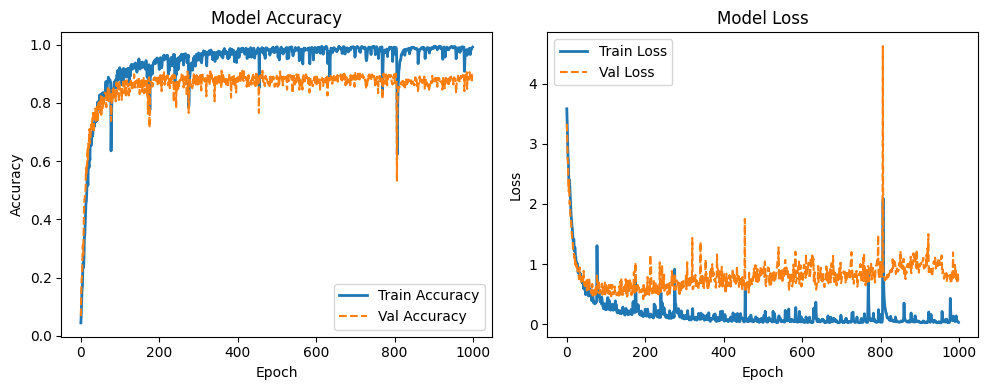

In [29]:
# --- Plot Training ---
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
os.makedirs("models", exist_ok=True)

model_path = os.path.join("models", f"{model_name}.keras")
label_path = os.path.join("models", f"{model_name}_label.pkl")

model.save(model_path)

with open(label_path, "wb") as f:
    pickle.dump(label_encoder, f)

print(f"✅ Model disimpan sebagai {model_path}")
print(f"✅ Label encoder disimpan sebagai {label_path}")


✅ Model disimpan sebagai models\sign_classifier_word.keras
✅ Label encoder disimpan sebagai models\sign_classifier_word_label.pkl


In [21]:
import tensorflow as tf
import os

os.makedirs("models", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

tflite_path = os.path.join("models", f"{model_name}.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\WINDOW~1\AppData\Local\Temp\tmp5gwxol7k\assets


INFO:tensorflow:Assets written to: C:\Users\WINDOW~1\AppData\Local\Temp\tmp5gwxol7k\assets


Saved artifact at 'C:\Users\WINDOW~1\AppData\Local\Temp\tmp5gwxol7k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 126), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)
Captures:
  2226197127120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226197125776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226197128272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226197127312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226197127888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226197129616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226197127504: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [23]:
import os
import pickle

os.makedirs("models", exist_ok=True)

label_path = os.path.join("models", f"{model_name}_label.pkl")
with open(label_path, "rb") as f:
    le = pickle.load(f)

labels = le.classes_

txt_path = os.path.join("models", "labels_word.txt")
with open(txt_path, "w") as f:
    for label in labels:
        f.write(label + "\n")

print(f"✅ Labels berhasil disimpan di {txt_path}")

✅ Labels berhasil disimpan di models\labels_word.txt
